WHAT IF 3: senza una stazione

# Libraries

In [25]:
import pandas as pd
import numpy as np
import random
import json
import pickle
import ast
from geopy import distance
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
from collections import Counter
import calendar
from datetime import datetime, timedelta

# statistical
from sklearn.neighbors import KernelDensity
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

base_path = '/content/gdrive/MyDrive/complexsystems/'

Mounted at /content/gdrive


# Functions

In [3]:
def transform_data(df):
  df = df.copy().dropna()
  
  df['started_at_round'] = pd.to_datetime(df['time1'], errors='coerce')
  df['ended_at_round'] = pd.to_datetime(df['time2'], errors='coerce')
  df['start'] = df['started_at_round'].dt.strftime('%H:%M')
  df['end'] = df['ended_at_round'].dt.strftime('%H:%M')
  
  df['day'] = df['started_at_round'].dt.date
  df['month'] = df['started_at_round'].dt.month
  df['week'] = df['started_at_round'].dt.isocalendar().week
  df['weekday'] = df['started_at_round'].dt.dayofweek

  df['season'] = df['started_at_round'].dt.month % 12 // 3 + 1 # le raggruppa a inizio mese, non nella data precisa
  df['weekend'] = df['started_at_round'].dt.dayofweek > 4
  df['hour_group'] = regroup_values(list(df['started_at_round'].dt.hour), 3)
  return df

# into intervals of size n
def regroup_values(values, n):
  return [n*(h//n) for h in values]

# Analysis

### Read files

In [82]:
df = pd.read_csv(base_path+'data/preprocessed/preprocessed_data_san_jose.csv', converters={"coords1": ast.literal_eval,"coords2": ast.literal_eval})
real = transform_data(df)
STATIONS = set(df['id1']).union(set(df['id2']))

In [90]:
files = os.listdir(base_path+'/data/simulation_history_whatif_3')
files1 = [f for f in files if '311' in f]
files2 = [f for f in files if '311' not in f]

In [92]:
# simulation data
rimosso = []
completo = []
for f in files1:
  h = pd.read_csv(base_path+'data/simulation_history_whatif_3/'+f)
  h['time1'] = pd.to_datetime(h['time1'])
  h['time2'] = pd.to_datetime(h['time2'])
  # h = h[~h['lost']]
  rimosso.append(h)
for f in files2:
  h = pd.read_csv(base_path+'data/simulation_history_whatif_3/'+f)
  h['time1'] = pd.to_datetime(h['time1'])
  h['time2'] = pd.to_datetime(h['time2'])
  # h = h[~h['lost']]
  completo.append(h)

# real data
real = df.copy()
dt1 = files[0][(files[0].index('start')+5):(files[0].index('start')+15)]
dt2 = files[0][(files[0].index('end')+3):(files[0].index('end')+13)]
real = real[(real['time1']>=dt1) & (real['time1']<dt2)].sort_values(by='time1')
real['time1'] = pd.to_datetime(real['time1'])
real['time2'] = pd.to_datetime(real['time2'])

### Trips

In [132]:
print('totali:', len(real))

totali: 7071


In [93]:
print('TOTALI')
tmp = [len(h[~h['lost']]) for h in rimosso]
print('rimosso', np.mean(tmp), np.std(tmp))
tmp = [len(h[~h['lost']]) for h in completo]
print('completo', np.mean(tmp), np.std(tmp))

print('\n--------------------\n')

print('PERSI')
tmp = [len(h[h['lost']]) for h in rimosso]
print('rimosso', np.mean(tmp), np.std(tmp))
tmp = [len(h[h['lost']]) for h in completo]
print('completo', np.mean(tmp), np.std(tmp))

TOTALI
rimosso 1084.7 885.1004142657112
completo 1027.3666666666666 516.1441325400838

--------------------

PERSI
rimosso 6904.066666666667 4238.407113789592
completo 6963.733333333334 3489.5116939512072


test statistico: https://www.reneshbedre.com/blog/mann-whitney-u-test.html

In [105]:
m1 = [len(h[~h['lost']]) for h in rimosso]
m2 = [len(h[~h['lost']]) for h in completo]

print(stats.shapiro(m1))
print(stats.shapiro(m2)) 
# not normally distributed => use mann-whitney

print(stats.mannwhitneyu(x=m1, y=m2, alternative='two-sided')) # non significativamente diverse

ShapiroResult(statistic=0.7918127775192261, pvalue=4.666592940338887e-05)
ShapiroResult(statistic=0.921235978603363, pvalue=0.028879407793283463)
MannwhitneyuResult(statistic=425.5, pvalue=0.7227124048439484)


In [106]:
m1 = [len(h[h['lost']]) for h in rimosso]
m2 = [len(h[h['lost']]) for h in completo]
stats.mannwhitneyu(x=m1, y=m2, alternative='two-sided') # non significativamente diverse

MannwhitneyuResult(statistic=423.0, pvalue=0.6952153990669099)

In [ ]:
# ----------------

In [120]:
dur1 = [list(h[~h['lost']]['duration']) for h in rimosso]
dur1 = [item for sublist in dur1 for item in sublist]

dur2 = [list(h[~h['lost']]['duration']) for h in completo]
dur2 = [item for sublist in dur2 for item in sublist]

len(dur1), len(dur2)

(32541, 30821)

In [124]:
print(np.mean(dur1), np.std(dur1))
print(np.mean(dur2), np.std(dur2))

12.6979810085738 8.06462206479881
12.212777002692969 8.118250608376709


In [130]:
stats.mannwhitneyu(x=dur1, y=dur2, alternative='two-sided') # DIVERSE!

MannwhitneyuResult(statistic=525794852.0, pvalue=5.1739164588713355e-28)

### Stations

Real data
7071


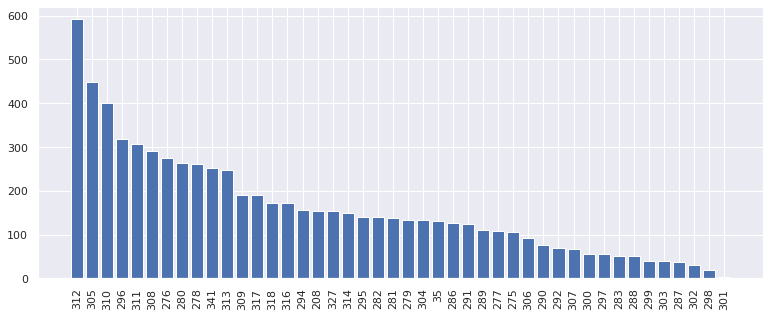

Simulation RIMOSSO
1084.7


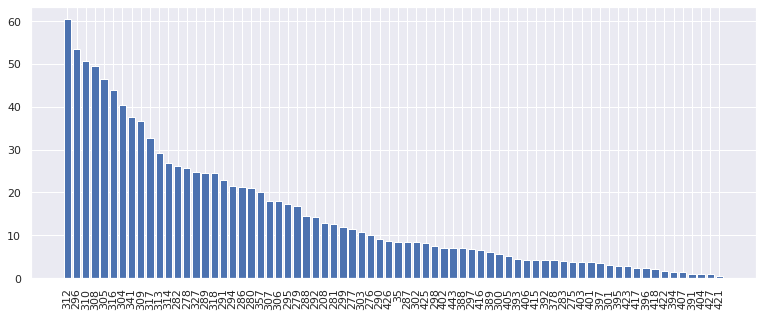

Simulation COMPLETO
1027.3666666666668


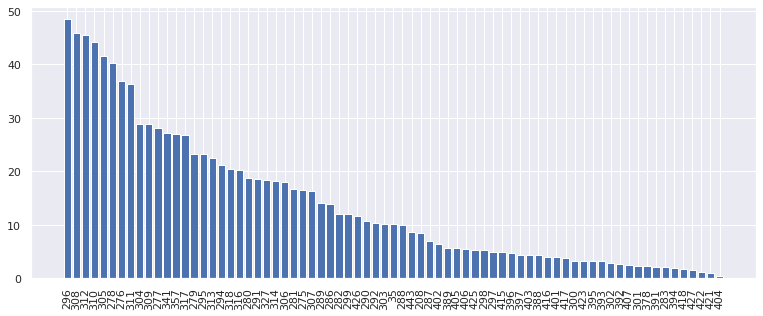

In [141]:
plt.rcParams["figure.figsize"] = (13,5)

print('Real data')
x = pd.value_counts(real['id1'])
labels = [str(l) for l in x.index]
count = list(x)
print(np.sum(count))
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation RIMOSSO')
tmp = [pd.value_counts(h[~h['lost']]['id1']).to_dict() for h in rimosso]
f = {}
for d in tmp:
  for k in d:
    if k not in f:
      f[k] = []
    f[k].append(d[k])
for k in f:
  f[k] = np.sum(f[k]) / len(rimosso)
tmp = pd.DataFrame([f]).T.sort_values(by=0, ascending=False)
tmp.index = tmp.index.map(str)
print(np.sum(tmp[0]))
plt.bar(tmp.index, tmp[0])
plt.xticks(rotation=90)
plt.show();

print('Simulation COMPLETO')
tmp = [pd.value_counts(h[~h['lost']]['id1']).to_dict() for h in completo]
f = {}
for d in tmp:
  for k in d:
    if k not in f:
      f[k] = []
    f[k].append(d[k])
for k in f:
  f[k] = np.sum(f[k]) / len(completo)
tmp = pd.DataFrame([f]).T.sort_values(by=0, ascending=False)
tmp.index = tmp.index.map(str)
print(np.sum(tmp[0]))
plt.bar(tmp.index, tmp[0])
plt.xticks(rotation=90)
plt.show();

### Trips

In [ ]:
tmp = real[(real['duration']>=1) & (real['duration']<=100)].copy()
dr = tmp['duration'].describe()
d1 = h1['duration'].describe()
d2 = h2['duration'].describe()
d3 = h3['duration'].describe()

tmp = pd.DataFrame(pd.concat([dr, d1, d2, d3], axis=1))
tmp.columns = ['real', 'h1', 'h2', 'h3']
tmp

Real data


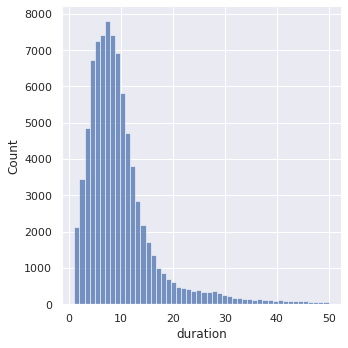

Simulation 1


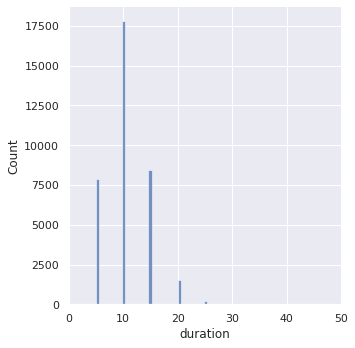

Simulation 2


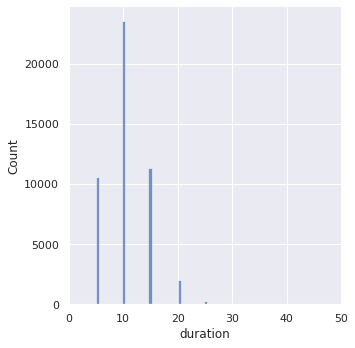

Simulation 3


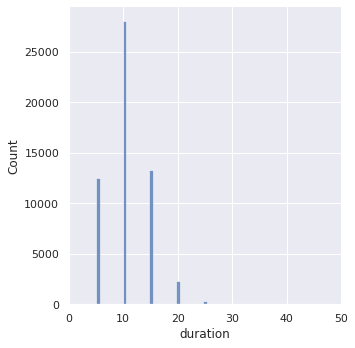

In [ ]:
xmax = 50

print('Real data')
tmp = real.copy()
tmp = tmp[tmp['duration']<=xmax]
sns.displot(tmp['duration'], bins=50)
plt.show();

print('Simulation 1')
sns.displot(h1['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

print('Simulation 2')
sns.displot(h2['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

print('Simulation 3')
sns.displot(h3['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

### Bikes

Real data
904 bikes


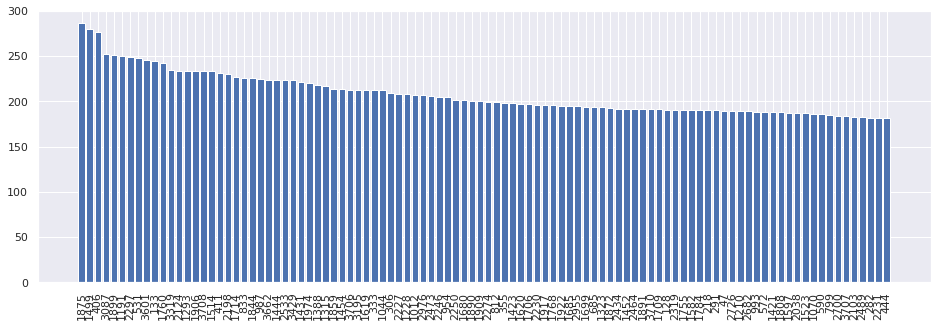

Simulation 1
394 bikes


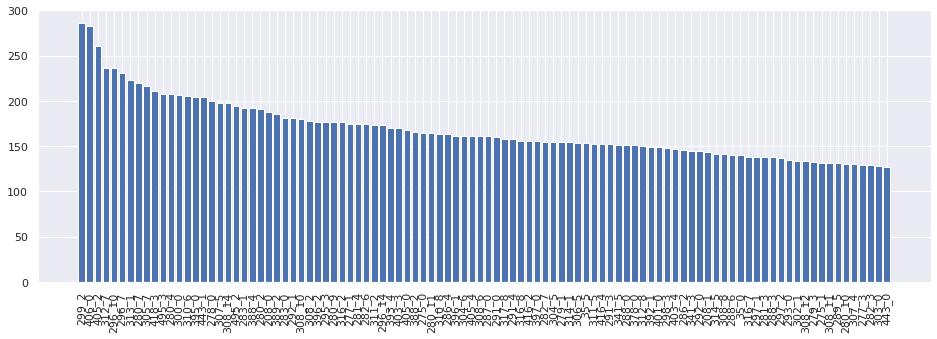

Simulation 2
887 bikes


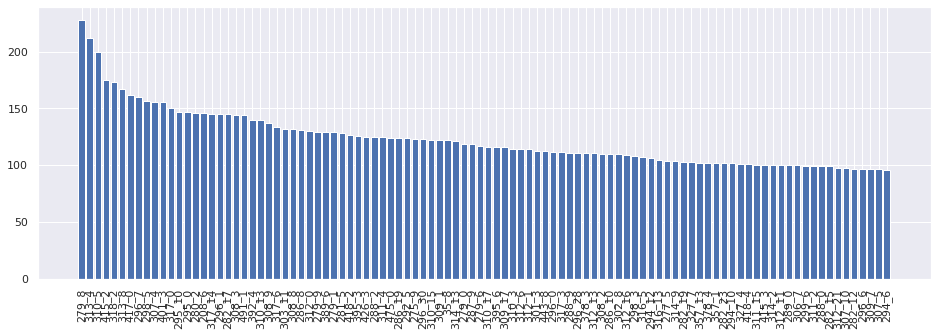

Simulation 3
1370 bikes


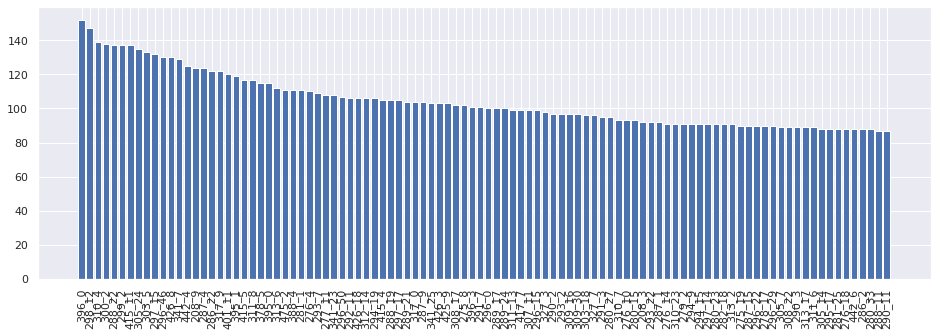

In [ ]:
plt.rcParams["figure.figsize"] = (16,5)

print('Real data')
x = pd.value_counts(real['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 1')
x = pd.value_counts(h1['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 2')
x = pd.value_counts(h2['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation 3')
x = pd.value_counts(h3['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

### Lost trips

In [ ]:
tmp = h1[h1['lost']]
tmp = pd.value_counts(tmp['id1'])
print('Total lost trips in h1:', np.sum(tmp))

tmp = h2[h2['lost']]
tmp = pd.value_counts(tmp['id1'])
print('Total lost trips in h2:', np.sum(tmp))

tmp = h3[h3['lost']]
tmp = pd.value_counts(tmp['id1'])
print('Total lost trips in h3:', np.sum(tmp))

# stazioni con più viaggi persi sono nello stesso ordine delle stazioni più usate

Total lost trips in h1: 179833
Total lost trips in h2: 167064
Total lost trips in h3: 157364
